In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import recall_score, confusion_matrix, ConfusionMatrixDisplay, SCORERS
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [2]:
filepath = '../data/eda_data.csv'
data = pd.read_csv(filepath)

In [3]:
X = data.drop('HRFS12M1', axis=1)
y = data['HRFS12M1']

In [4]:
X.columns

Index(['HURESPLI', 'HUFINAL', 'HULANGCODE', 'HETENURE', 'HEHOUSUT', 'HETELHHD',
       'HETELAVL', 'HEPHONEO', 'HEFAMINC', 'HUTYPEA',
       ...
       'HESC2', 'HESC3', 'HESCF3', 'HESCM3', 'HESC3A', 'HESC4', 'HESCF4',
       'HESCM4', 'HRSUPINT', 'HRPOOR'],
      dtype='object', length=469)

After identifying the data leak, the columns were passed to the eda pipeline and removed. The below is no longer necessary to run, but left to show the process

In [5]:
#data consists of ints representing classes, so need to create dummies for every column
# X_dum = pd.get_dummies(data=X, columns=X.columns)

In [6]:
#break the data into train (X_train, y_train), validation (X_val, y_val), and test (X_test, y_test).
#set random state for reproduceability
#data in imbalanced; stratify preserves the imbalance
# X_sub, X_test, y_sub, y_test = train_test_split(X_dum, y, random_state=1234, stratify=y)
# X_train, X_val, y_train, y_val = train_test_split(X_sub, y_sub, random_state=1234, stratify=y_sub)

In [12]:
# #Test 3 different models to see which we can use for our base
# #All 3 had a recall of >99%. There are likely more features causing data leakage that will need to be addressed
# models = [MLPClassifier(), RandomForestClassifier(), GradientBoostingClassifier()]

# for model in models:
#     mod = model
#     mod.fit(X_train, y_train)
#     y_pred = mod.predict(X_val)
#     recall = recall_score(y_val, y_pred)
#     print(model, recall)

MLPClassifier() 0.9987460815047022
RandomForestClassifier() 0.993103448275862
GradientBoostingClassifier() 0.9987460815047022


In [7]:
# rfc = RandomForestClassifier()
# rfc.fit(X_train, y_train)

# feat_scores = pd.DataFrame({'Fraction of Samples Affected' : rfc.feature_importances_},
#                            index=X_train.columns)
# feat_scores = feat_scores.sort_values(by='Fraction of Samples Affected')

In [8]:
# Taking a look at the 50 'top' columns. These included dummies, so removed the dummy addition to col
# name and use list-set trick to find only unique col names. Referenced the accompanying PDF
# to determine if they are in fact data leakage. Erred on the side of caution as the questions near
# the line are difficult to distinguish as data leak vs not
# feat_list = []
# for feat in feat_scores[-50:].index:
#     feat_list.append(feat.split('_')[0])
    
# feat_unique = list(set(feat_list))
# print(feat_unique)

['HESH4', 'HESHF3', 'HESHM3', 'HESSM4', 'HETSHMF3', 'HESH3', 'HESSH1', 'HESS3', 'HESS2', 'HESSM6', 'HESS4', 'HESSH4', 'HESSH3', 'HESH2', 'HESH5', 'HESSH5', 'HESS6', 'HETSHMF2', 'HESHM2', 'HESSM3', 'HESHF2', 'HES9', 'HESSM2', 'HESSH2', 'HESS1', 'HESSM5']


In [10]:
X_dum = pd.get_dummies(data=X, columns=X.columns)
X_train, X_test, y_train, y_test = train_test_split(X_dum, y, random_state=1234, stratify=y)
X_sub, X_val, y_sub, y_val = train_test_split(X_train, y_train, random_state=1234, stratify=y_train)

0.6238244514106583


3035

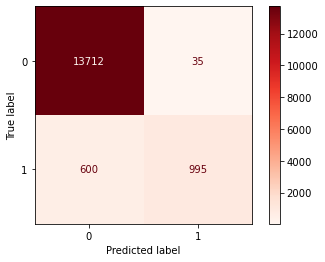

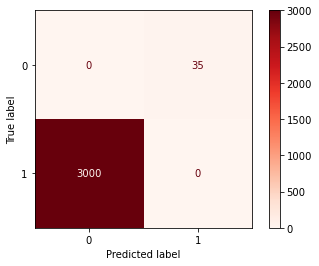

In [11]:
#Recall fell significantly. We appear to have removed all data leakage
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_val)
recall = recall_score(y_val, y_pred)
print(recall)

# plot a confusion matrix to get a better idea of how the model is predicting
conf_matrix = confusion_matrix(y_val, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap='Reds')

# Create a cost matrix to penalize False Negatives heavily, but also penalize False Positives
# Multiply the confusion matrix by the cost matrix to get the cost of the model
# We want to maximize recall while also decreasing the cost
cost_matrix = np.array([[0, 1],
                        [5, 0]])
cost_disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix * cost_matrix)
cost_disp.plot(cmap='Reds')
cost = np.sum(conf_matrix * cost_matrix)
cost

In [12]:
def recall_cost_calc(model, X_train, X_test, y_train, y_test, cost_matrix):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    recall = recall_score(y_test, y_pred)
    
    conf_matrix = confusion_matrix(y_test, y_pred)
    cost = np.sum(conf_matrix * cost_matrix)
    
    return recall, cost

In [13]:
def get_avg_recall_cost(model, X, y, cost_matrix):
    recall_list = []
    cost_list = []
    
    kf = KFold()
    
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        recall, cost = recall_cost_calc(model, X_train, X_test, y_train, y_test, cost_matrix)
        recall_list.append(recall)
        cost_list.append(cost)
        
    return np.mean(recall_list), np.mean(cost_list)

In [14]:
# find the average recall and cost for Random Forest
cost_matrix = np.array([[0, 1],
                        [5, 0]])

X_reset = X_sub.reset_index(drop=True)
y_reset = y_sub.reset_index(drop=True)

recall, cost = get_avg_recall_cost(RandomForestClassifier(), X_reset, y_reset, cost_matrix)

In [15]:
# Now we have something to compare with the other models
print(f'Random Forest recall: {recall}, cost: {cost}')

Random Forest recall: 0.6271847622541074, cost: 2417.4


In [18]:
# Run the other models through cross validation. The best performing model is what we'll 
# continue with and tune its hyperparameters
models = [MLPClassifier(), GradientBoostingClassifier()]

for model in models:
    recall, cost = get_avg_recall_cost(model, X_reset, y_reset, cost_matrix)
    print(f'{model} recall: {recall}, cost: {cost}')

MLPClassifier() recall: 0.7969173781324035, cost: 1493.2
GradientBoostingClassifier() recall: 0.7100260453280495, cost: 1990.6


In [16]:
random_forest_grid = {'max_depth': [None, 3, 5],
                      'max_features': ['sqrt', 'log2', None],
                      'min_samples_split': [2, 4, 8],
                      'min_samples_leaf': [1, 2, 4],
                      'bootstrap': [True, False],
                      'n_estimators': [50, 100, 150],
                      'random_state': [1],
                      'criterion': ['gini', 'entropy']}
    
model_gridsearch = GridSearchCV(RandomForestClassifier(),
                                random_forest_grid,
                                n_jobs=-1,
                                verbose=True,
                                scoring='recall')
model_gridsearch.fit(X_train, y_train)
best_params = model_gridsearch.best_params_ 
model_best = model_gridsearch.best_estimator_
print("\nResult of gridsearch:")
print("{0:<20s} | {1:<8s} | {2}".format("Parameter", "Optimal", "Gridsearch values"))
print("-" * 55)
for param, vals in random_forest_grid.items():
    print("{0:<20s} | {1:<8s} | {2}".format(str(param), 
                                            str(best_params[param]),
                                            str(vals)))

Fitting 5 folds for each of 972 candidates, totalling 4860 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 24.2min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 999.6min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 1118.7min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 1334.3min


KeyboardInterrupt: 

In [18]:
mlp_final = MLPClassifier()
mlp_final.fit(X_sub, y_sub)
y_prob = mlp_final.predict_proba(X_val)


0.025 0.8453177257525084 1466
0.05 0.8319397993311036 1467
0.1 0.81438127090301 1492
0.125 0.8085284280936454 1500
0.15 0.8035117056856187 1515


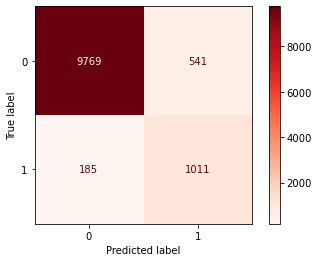

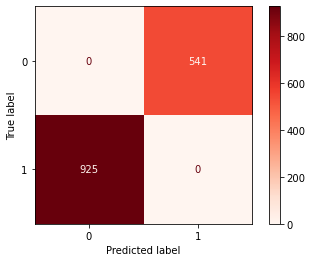

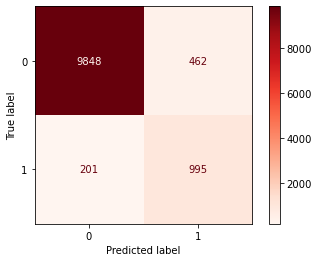

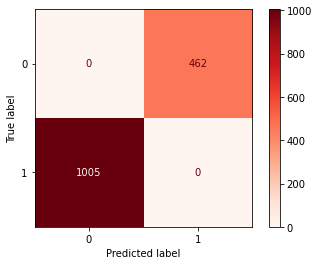

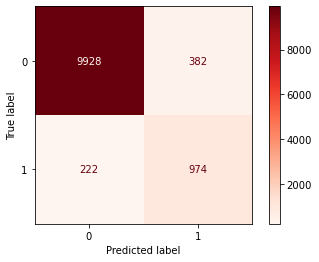

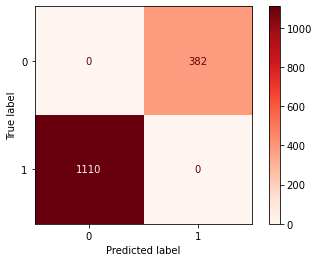

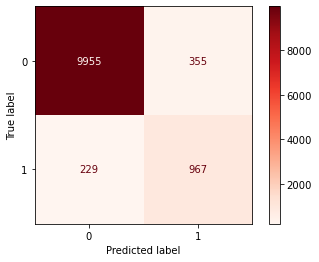

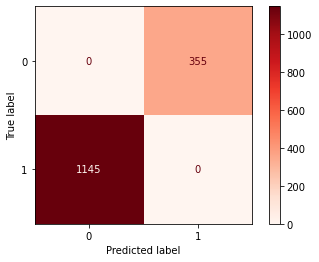

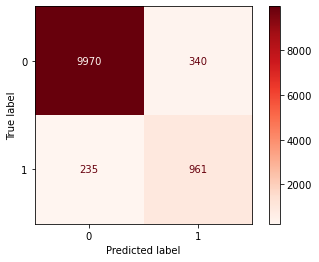

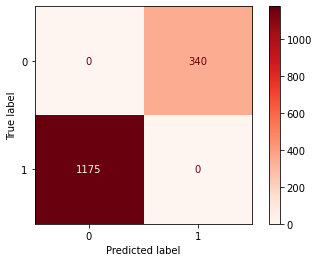

In [30]:
# started thresholds centered around .5, walked it down to the ideal at 0.025
thresholds = [.025, .05, .1, .125, .15]
cost_matrix = np.array([[0, 1],
                        [5, 0]])

for thres in thresholds:
    y_pred = y_prob[:,1] > thres
    y_pred = y_pred.astype(int)
    recall = recall_score(y_val, y_pred)
    

    conf_matrix = confusion_matrix(y_val, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
    disp.plot(cmap='Reds')


    cost_disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix * cost_matrix)
    cost_disp.plot(cmap='Reds')
    cost = np.sum(conf_matrix * cost_matrix)
    print(thres, recall, cost)

0.025 0.8533145275035261 2530


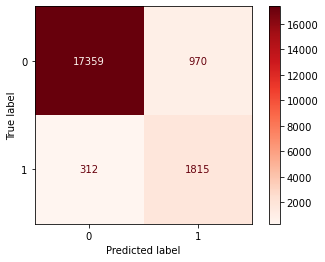

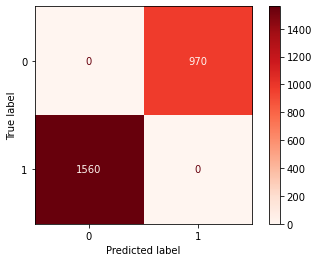

In [31]:
# FINAL T
y_final_prob = mlp_final.predict_proba(X_test)
cost_matrix = np.array([[0, 1],
                        [5, 0]])
thres = 0.025
y_final_pred = y_final_prob[:,1] > thres
y_final_pred = y_final_pred.astype(int)
final_recall = recall_score(y_test, y_final_pred)


final_conf_matrix = confusion_matrix(y_test, y_final_pred)
final_disp = ConfusionMatrixDisplay(confusion_matrix=final_conf_matrix)
final_disp.plot(cmap='Reds')


final_cost_disp = ConfusionMatrixDisplay(confusion_matrix=final_conf_matrix * cost_matrix)
final_cost_disp.plot(cmap='Reds')
final_cost = np.sum(final_conf_matrix * cost_matrix)
print(thres, final_recall, final_cost)

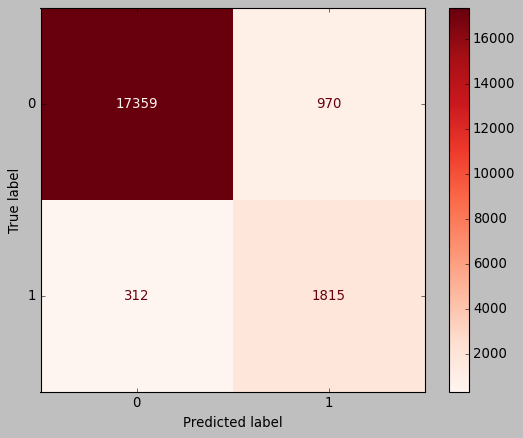

In [41]:
plt.style.use('classic')
final_disp.plot(cmap='Reds')
plt.savefig('../img/final_conf.png');

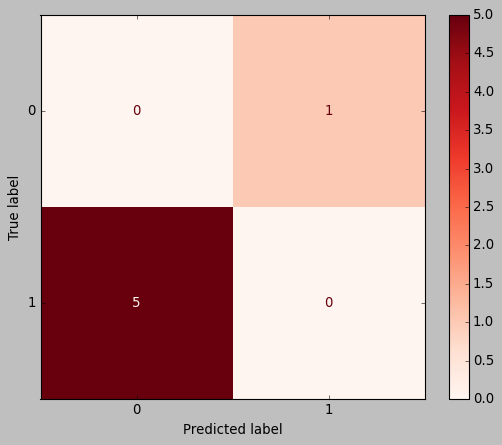

In [43]:
cost_disp = ConfusionMatrixDisplay(confusion_matrix=cost_matrix)
cost_disp.plot(cmap='Reds')
plt.savefig('../img/cost_matrix.png');

In [32]:
from joblib import dump, load

# save model to file to use for later (or other projects)
dump(mlp_final, 'mlp_food_insecurity.joblib')

# load model
# clf = load('mlp_food_insecurity.joblib')

['mlp_food_insecurity.joblib']